# Exercise Sheet 1 - CIFAR, MLP, Overfitting and Regularization

 * Deep Learning for Computer Vision – Winter Term 2024/25
 * Lecture by: Constantin Pape
 * Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
 * Due date: **Tuesday, Nov 5, before 10:00**


## Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**


## Topic

In this exercise sheet, you will:
- get to know a new dataset: CIFAR-10
- implement a MLP
- get more familiar with model fitting
- see overfitting
- implement early stopping
- explore hyperparameters and their influence
- vary architecture to improve model performance

*We are looking forward to seeing your solutions! Have fun!*


## IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all questions in written form!**
- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (.ipynb file). No other file is required.
    - Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 1`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand

Implementation:
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.

### How to work on the exercise?
You will need access to a machine with a GPU to properly work on the exercises. We recommend using [Kaggle](https://www.kaggle.com/), which offers convenient access to a GPU and has all the dependencies that we need preinstalled ([here](https://gist.github.com/anwai98/444d3ff11c1365f2c610579d5df0830b) are the initial steps to work the Kaggle Notebooks). You can load this notebook on kaggle via `File` -> `Import Notebook` -> `Browse Files` and `Import`

## Introduction

In this task you will build a multi layer perceptron (MLP) model with PyTorch and perform training and prediction on the CIFAR dataset.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:
- [PyTorch tutorial](https://pytorch.org/tutorials/)
- [Seaborn tutorial](https://seaborn.pydata.org/tutorial.html)

## Imports

Jupyter Notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [2]:
import os
import time
import pathlib
import fastprogress

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

### GPU and CUDA checks

Let's perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 2)

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.

Click the bottom-right corner menu `<` -> `Notebook options` -> `Accelerator` -> Select `GPU P100` as Hardware accelerator.

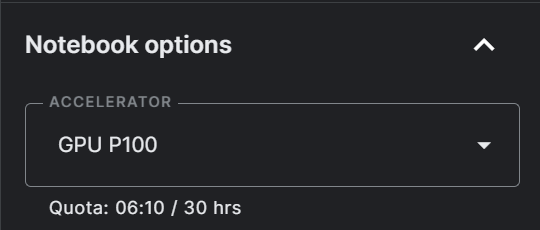

Now check the availability again (you would have to re-run the imports)

In [4]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 2)

In [5]:
# DO NOT CHANGE
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print(
        'cuda available:', torch.cuda.is_available(), 
        '; cudnn available:', torch.backends.cudnn.is_available(),
        '; num devices:', torch.cuda.device_count()
    )
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [6]:
# DO NOT CHANGE
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 2
Using device Tesla T4
4 CPUs available


## Deep Learning with PyTorch

The process of training and evaluating a deep learning model begins with data loading. A dataset needs to be chosen on which the model should be trained. This data might need some preprocessing (like resizing or normalizing) of images. Splitting of the data in different sets is necessary. We need a set to train on, a set to validate the training progress and a set to test the model after training.

The next step is to **specify the model and its optimizer**, as well as the loss function. An important hyperparameter is the learning rate which influences how big the changes of the parameters should be after calculating the loss.

The model fitting is split into training and evaluation. In the training process the model does a forward pass which means the data is presented to the model and the model outputs a prediction. The loss compares the prediction with the ground truth. In the backward pass the gradient with regard to the parameter is calculated and the parameter are updated by the gradient step. In the evaluation process the loss is computed on the entire validation set. This is done to see how well the model operates on data for which the params were not optimized before in order to avoid overfitting. The model fitting process is repeated for N epochs which is another hyperparameter that needs to be chosen carefully.

After the training we evaluate the final model on the test set.

We'll go through the individual steps in the course of this notebook.

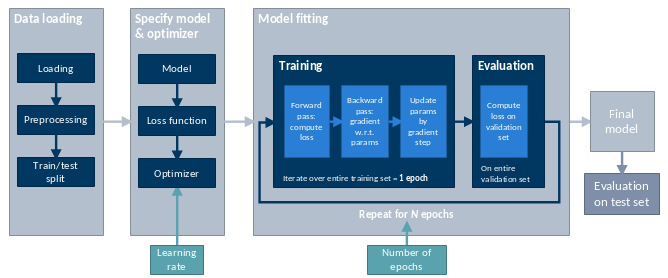

## Data Loading

## CIFAR dataset

This dataset contains natural images, and it is widely used by the machine learning community. It's really useful that you get accustomed with this dataset, as you'll come across it later to learn other concepts.

The first thing you should do when you begin to work with a data set that you have not used before is to play around with it to get a better understanding of its properties. Feel free to visualize the images to have a better understanding.

**Download** the CIFAR dataset using torchvision dataset classes.

In [7]:
# DO NOT CHANGE
data_dir = pathlib.Path("data/")
cifar = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 91763227.35it/s] 


Extracting data/cifar-10-python.tar.gz to data


Let's check the first sample to see what it looks like

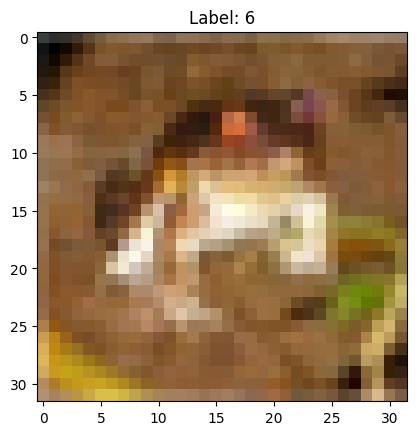

In [8]:
X_sample, y_sample = cifar[0]
# TODO: display the label and the image
X_sample_tensor = torchvision.transforms.functional.pil_to_tensor(X_sample)
plt.imshow(X_sample_tensor.permute(1,2,0))
plt.title(f'Label: {y_sample}')
plt.show()

Look at the types of X and y.

In [9]:
# TODO: display types
print(f'Type image: {type(X_sample)}')
print(f'Type label: {type(y_sample)}')

Type image: <class 'PIL.Image.Image'>
Type label: <class 'int'>


How many data points are there in the dataset?

In [10]:
# TODO: print out the length of the dataset
print(len(cifar))

50000


## Loading data

### Preprocessing the Data

#### Transformation

We have seen above that the contents of the data set are of type [(PIL.Image.Image, Int)]. However, `pytorch` (the core library, not `torchvision`) is only equipped to work on Tensor objects. So we need to transform _PIL.Image.Image_ to _torch.Tensor_. Torchvision takes care of that for us. _transforms.ToTensor_ is a transformation operation that maps a _PIL.Image.Image_ to a torch tensor.

#### Normalization

Furthermore, we will **normalize** the data to zero-mean and unit-variance. _transforms.Normalize_ takes the mean and std-dev for each channel and rescales the data to zero-mean, unit-variance.

See https://pytorch.org/vision/stable/transforms.html for more information.

We can combine multiple transformations via _transforms.Compose_.

In [11]:
# DO NOT CHANGE
def grab_data(data_dir, num_cpus=1):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(
        data_dir, train=True, download=True, transform=torchvision.transforms.ToTensor()
    )

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=num_samples, num_workers=num_cpus
    )
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(
        data_dir, download=True, train=True, transform=normalized_transform
    )

    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(
        data_dir, download=True, train=False, transform=normalized_transform
    )

    return trainset, testset, dataset_mean, dataset_std

#### Training, Validation and Test Sets

For the correct ftting of a neural network, we need three dataset components: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data.

Note that you should not use the test set in any part of your training and model selection procedure. It should only be used for showing the final results.

We first need to **load** the datasets (above we did that already to calculate the normalization values. Then, we load them and **apply the normalization transform**)

We also need to **split** the train dataset into two sets, one for training and one for validation. While the training set needs to be quite large, the validation set can be relatively small. Take 10% of the dataset as validation set. Assign samples _randomly_ to the training and validation set, using a fixed seed to ensure reproducibility.

In [12]:
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(
        trainset, (num_train_samples, num_val_samples), generator=torch.Generator().manual_seed(split_seed)
    )
    return trainset, valset

To load the data for model training, we need to define **dataloaders**. A dataloader represents a Python iterable over a dataset and draws mini batches with random samples. Obseve below that we have a default number for batch size, and we shuffle the samples in batches.

In [13]:
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )

    return trainloader, valloader, testloader

#### TODO
- Load the CIFAR 10 train and test data set using the functions defined above
- Generate a validation set from 20% of the training set samples. *Remember:* Keep the seed for the validation set generation fixed for reproducibility.
- Generate torch data loaders for the train, validation and test data set splits. Use a batch size of 1024.

*Hint:* we will use the mean and standard deviation returned by ```grab_data``` later

In [14]:
batch_size = 1024
random_seed = 42

trainset, testset, dataset_mean, dataset_std = grab_data(data_dir, num_cpus=1)
trainset, valset = generate_train_val_data_split(trainset, split_seed=random_seed, val_frac=0.2)
trainloader, valloader, testloader = init_data_loaders(trainset, 
                                                       valset, 
                                                       testset, 
                                                       batch_size=batch_size, 
                                                       num_cpus=1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Let's have a look at the dataset.

#### TODO
- Print all the class names
- Plot 16 images randomly drawn from the training set with their according class label

*Hint:* Since you normalized the dataset before, you have to undo that operation for plotting

In [19]:
def imshow(img, mean, std):
    """Undo normalization using mean and standard deviation and show image.

    Args:
        img (torch.Tensor): Image to show
        mean (np.array shape (3,)): Vector of means per channel used to
            normalize the dataset.
        std (np.array shape (3,)): Vector of standard deviations per channel 
            used to normalize the dataset.
    """
    # Define function to plot
    img = img.permute(1,2,0)
    img = img * std + mean
    plt.figure(figsize = (12,6))
    plt.imshow(img.permute(0, 1, 2))
    plt.axis('off')
    plt.show()
    ####################
    ## YOUR CODE HERE ##
    ####################

In [20]:
ind = np.random.choice(range(batch_size),16)
mini_batch = next(iter(trainloader))
images = mini_batch[0][ind]
labels = mini_batch[1][ind]

In [21]:
classes = [c.item() for c in torch.unique(mini_batch[1])]
classes_names = [cifar.classes[x] for x in torch.unique(mini_batch[1]).tolist()]
print('Classes:', *classes, sep = '  ')
print('Classes Names:', *classes_names, sep = '  ')

Classes:  0  1  2  3  4  5  6  7  8  9
Classes Names:  airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


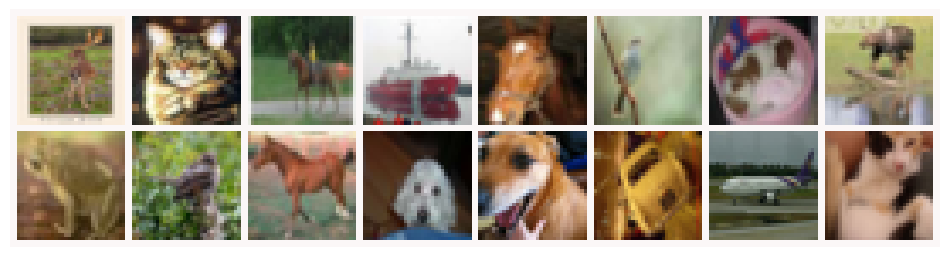

deer  cat  horse  ship  horse  bird  dog  deer  frog  bird  horse  dog  dog  automobile  airplane  cat


In [22]:
# Create actual plot and print the class names
images_grid = torchvision.utils.make_grid(images, nrow=8, pad_value = 2)
imshow(images_grid, dataset_mean, dataset_std)
labels_names = [cifar.classes[x] for x in labels.tolist()]
print(*labels_names, sep = '  ')

Now that you know what CIFAR10 looks like, you can guess what the task for this dataset is: classification in natural images

## Training, evaluation and plotting functions

Here, we provide examples of training, evaluation and plotting functions. Some parts are still missing. You can ignore this for the time being and move to the next section "**MLP Model**". You will implement the missing parts of these functions when required in the next sections.

In [23]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        #y = nn.functional.one_hot(y, num_classes=10).float() #CHANGED
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            y = nn.functional.one_hot(y, num_classes=10).float() 
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False
):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(
            train_dataloader, optimizer, model, loss_function, device, master_bar
        )
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(
            val_dataloader, model, loss_function, device, master_bar
        )

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        
        if early_stopper:
            early_stopper.update(val_accs[-1], model)
            if early_stopper.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                early_stopper.load_checkpoint(model)
                break

            #raise NotImplementedError # Comment out this keyword after your implementation

            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(
    title, label, train_results, val_results, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None
):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        # extra_pt - number of extra points
        plt.plot(epoch_array[-extra_pt:], train_results[-extra_pt:],'ko') 
        plt.plot(epoch_array[-extra_pt:], val_results[-extra_pt:],'ko') 
        legend.append(extra_pt_label)
        
        #raise NotImplementedError # Comment out this keyword after your implementation

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

## MLP model

#### TODO
- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings
- There should be a non-linearity after the input layer and in the hidden layers, i.e. in all layers that map to hidden units, but not in the final (linear) layer that creates the outputs

*Hint*: As CIFAR 10 contains color images, amongst other dimensions you want to flatten the color channel dimension, too.

In [24]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(
        self, img_width, num_in_channels, num_classes, num_hidden_units=30, num_hidden_layers=1, act_fn=None
    ):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        
        super().__init__()
    
        if not act_fn:
            self.act_fn = nn.ReLU()
        in_channels = num_in_channels*img_width*img_width
        self.first_layer = nn.Linear(in_channels , num_hidden_units)
        self.module_list = nn.ModuleList([nn.Linear(num_hidden_units, num_hidden_units) for i in range(num_hidden_layers)])
        self.last_layer = nn.Linear(num_hidden_units , num_classes)

    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        x = torch.flatten(x, start_dim = 1, end_dim = 3)
        x = self.first_layer(x)
        x = self.act_fn(x)
        for hidden_layer in self.module_list:
            x = hidden_layer(x)
            x = self.act_fn(x)
        
        x = self.last_layer(x)
        return x
        


## Model training: learning rate

One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.

So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.

For optimization, we use the commonly used Adam optimizer (not SGD), since it behaves very robustly and is easy to use.

#### TODO:
- Instantiate a MLP model with one hidden layer and ReLU activation function 
- Train the model for 10 epochs
- Use the Adam optimizer
- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train
- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.

*Hints:*

**This is an example of a model that does not train sufficiently:** *(Why?)*

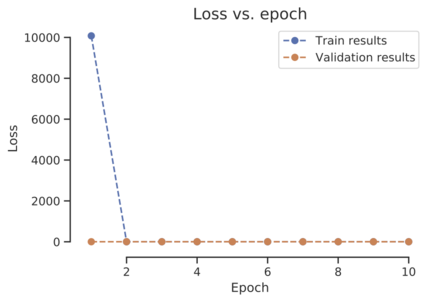

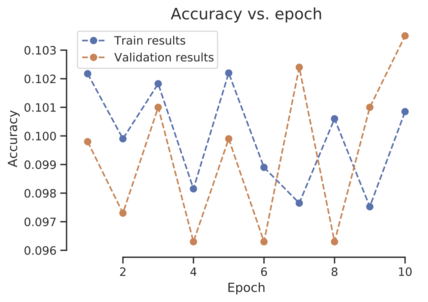

**This is an example of a model that does train:** *(Why?)*

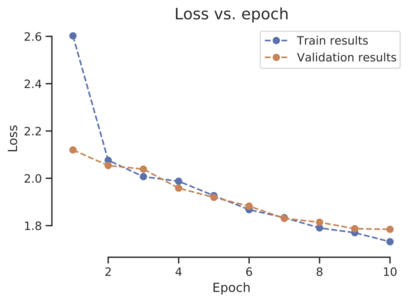

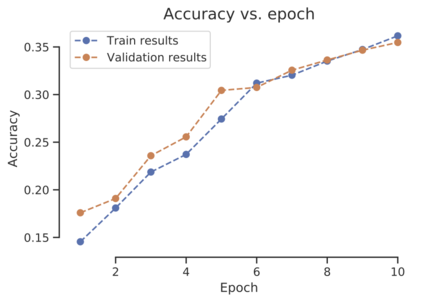

In [25]:
num_in_channels, img_width, _ =  X_sample_tensor.shape
num_classes = 10

In [26]:
def show_plots(train_losses, val_losses,train_accs, val_accs):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
    n_epochs = len(train_losses)
    ax[0].plot(range(1, n_epochs+1), train_losses, label = 'Train loss')
    ax[0].plot(range(1, n_epochs+1), val_losses, label = 'Val loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss plot')
    ax[0].legend()

    ax[1].plot(range(1, n_epochs+1), train_accs, label = 'Train accuracy')
    ax[1].plot(range(1, n_epochs+1), val_accs, label = 'Val accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Accuracy plot')
    ax[1].legend()

    return fig

Finished training after 114 seconds.


Finished training after 115 seconds.


Finished training after 114 seconds.


Finished training after 115 seconds.


Finished training after 116 seconds.


Finished training after 114 seconds.


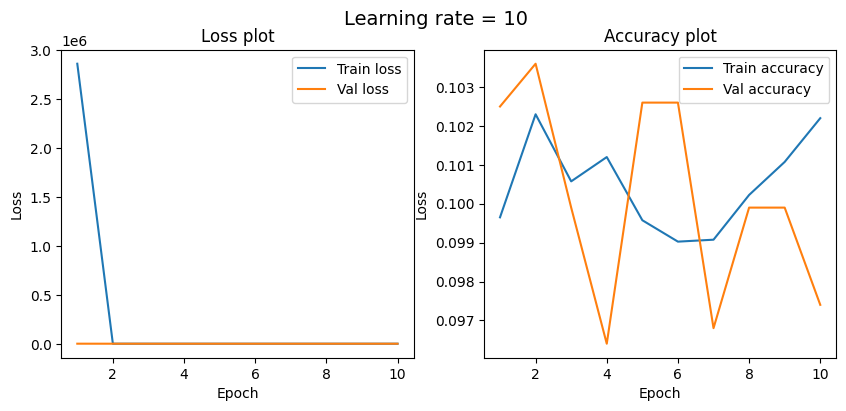

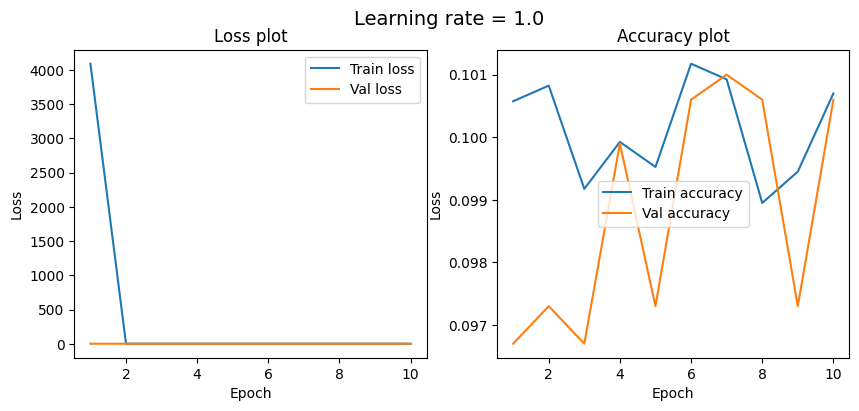

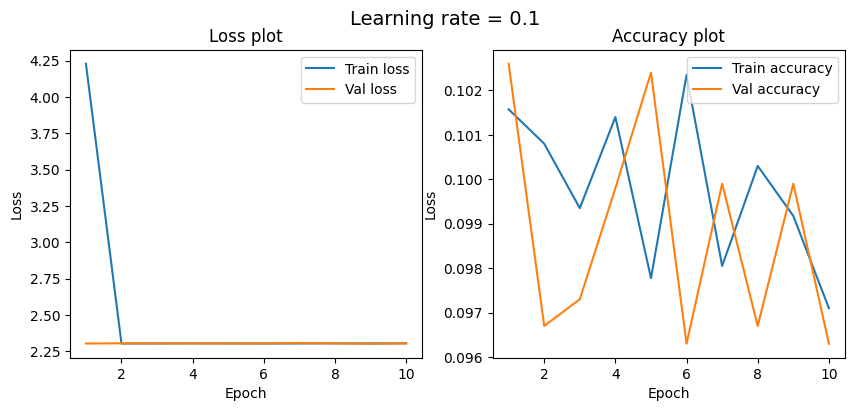

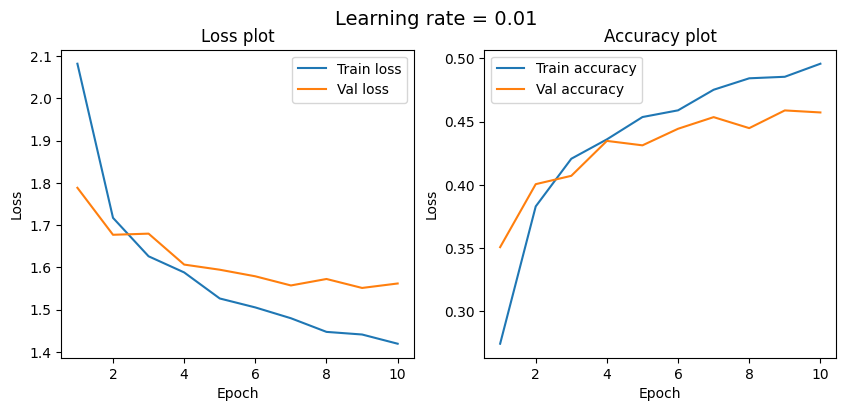

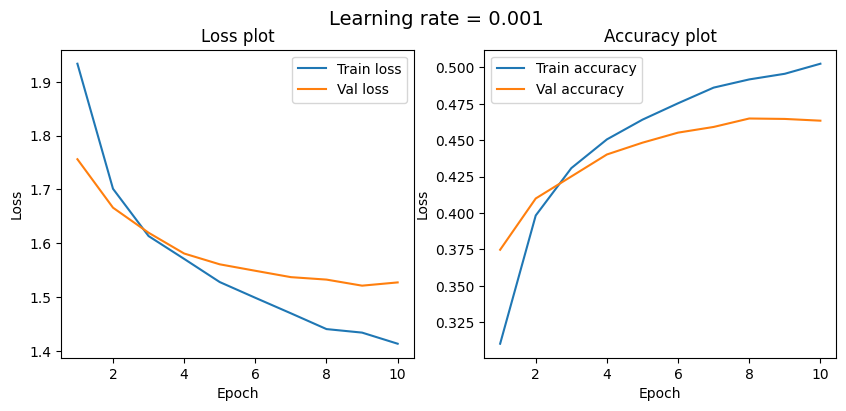

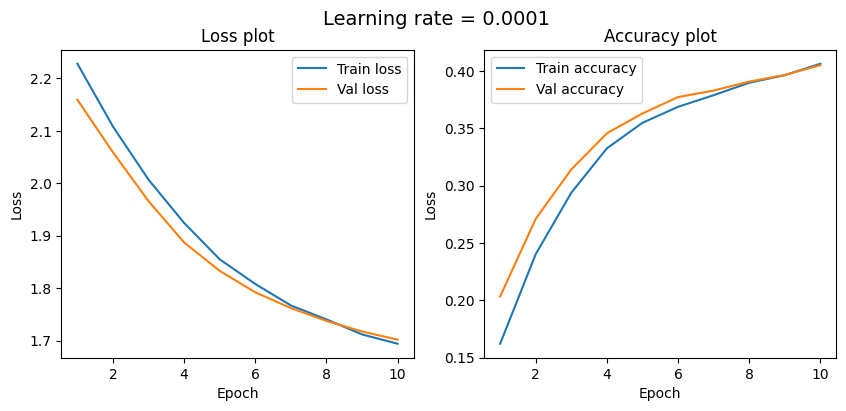

In [22]:
learning_rate = 10
history_plots = []
while learning_rate >= 0.0001:
    num_epochs = 10
    model = MLP(img_width, num_in_channels, num_classes ).to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    loss_function = nn.CrossEntropyLoss()
    
    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
                 optimizer, 
                 loss_function, 
                 device, 
                 num_epochs, 
                 train_dataloader = trainloader, 
                 val_dataloader = valloader, 
                 early_stopper=None, 
                 verbose=False)
    
    fig = show_plots(train_losses, val_losses,train_accs, val_accs)
    fig.suptitle(f'Learning rate = {learning_rate}', fontsize=14)
    
    learning_rate = learning_rate/10

Has your model already converged, i.e. reached the highest accuracy on the validation set? Probably not. So here are your TODOs:

#### TODO:
- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)

#### TODO from now on, for all subsequent tasks:
- Print the overall best value and the epoch at which it occurred of:
    - val loss and
    - val accuracy

In [41]:
def best_val_epoch(val_losses, val_accs):
    ind_accs = np.argmax(val_accs)
    ind_loss = np.argmin(val_losses)
    best_acc = val_accs[ind_accs]
    best_loss = val_losses[ind_loss]
    print(f'The best value of accuracy of {round(best_acc,2)}, occured at {ind_accs} epoch')
    print(f'The best value of loss of {round(best_loss,2)}, occured at {ind_loss} epoch')

In [24]:
num_epochs = 100
model = MLP(img_width, num_in_channels, num_classes ).to(device)
optimizer = optim.Adam(model.parameters())

loss_function = nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
             optimizer, 
             loss_function, 
             device, 
             num_epochs, 
             train_dataloader = trainloader, 
             val_dataloader = valloader, 
             early_stopper = False, 
             verbose=False)

Finished training after 1146 seconds.


The best value of accuracy of 0.48, occured at 26 epoch
The best value of loss of 1.49, occured at 15 epoch


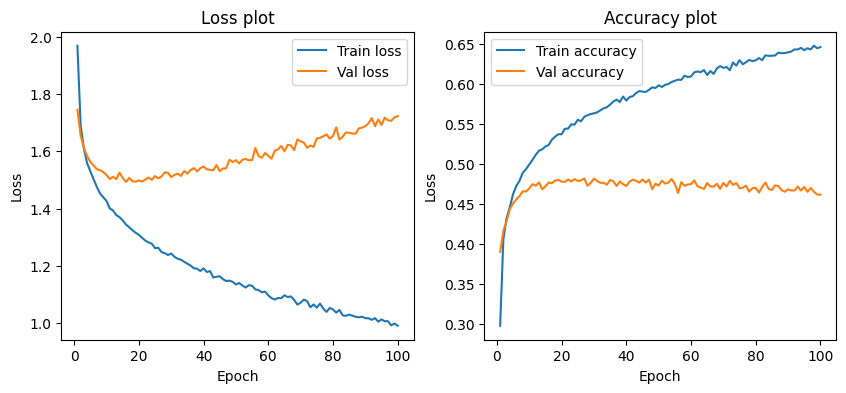

In [25]:
best_val_epoch(val_losses, val_accs)
res = show_plots(train_losses, val_losses,train_accs, val_accs)

Let's have a look at those training curves! Here are some questions for you.

#### TODO:
Answer the following questions in written form, as they are really crucial for the rest of this course.

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the minimum of the curves.)
1. Do the training and validation accuracy increase after each epoch? Why? // Why not?
1. Are the epochs at which you got the best validation loss and the best validation accuracy the same?
1. (Optional): Do you have any ideas why not?
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

### Your answers:

1. **Does the training loss decrease after each epoch? Why or why not?**
Training loss generally decreases with each epoch because the model is optimizing its weights to better fit the training data. However, it may not always decrease if the learning rate is too high, causing the model to "jump" past optimal points, or if the model is too simple to capture the data’s complexity.

2. **Does the validation loss decrease after each epoch? Why or why not?**
Validation loss may decrease initially as the model learns patterns from the data, but it often begins to fluctuate and might increase later on if the model starts overfitting. Fluctuations are normal due to variations in the validation set, and the minimum point of the validation loss curve indicates the model's best generalization before overfitting starts.

3. **Do the training and validation accuracy increase after each epoch? Why or why not?**
Training accuracy generally increases over time as the model better fits the training data. Validation accuracy may increase initially but can plateau and even decrease as the model overfits. High variability in validation accuracy can also be due to randomness in data or if the model is close to its capacity limit.
4. **(And 5) Are the epochs at which you got the best validation loss and the best validation accuracy the same? Why?**
The epochs with the best validation loss and best validation accuracy are often not the same. For example, in our case, the best validation loss occurred at epoch 15, whereas the best validation accuracy was reached later, at epoch 26. This discrepancy happens because validation loss and validation accuracy measure different aspects of model performance, and each can fluctuate after a certain point in training.
After several epochs, the model begins to overfit, capturing noise and specific details from the training data rather than general patterns. As a result, validation loss often starts to increase or fluctuate as the model struggles to generalize. However, validation accuracy may still improve in some epochs by chance, as the model might correctly classify some validation samples, even if its generalization ability is not truly improving.
This randomness in validation accuracy occurs because small changes in weights can have a bigger impact on classification (discrete outcomes) than on loss (continuous measure). Consequently, the best validation accuracy can occur at different epochs, often later in training, even if validation loss has already reached its minimum.
6. **At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why?**
The best model for making predictions is typically the one with the lowest validation loss before any significant increase or plateau occurs. This indicates that the model is well-tuned for generalization to unseen data. Based on our analysis, the model would be best saved around epochs 10-15, where we observe optimal validation loss and accuracy without excessive signs of overfitting. At this stage, the gap between training and validation metrics is minimal, suggesting that the model has not yet begun to overfit significantly.

## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO:
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.

*Hints:*
- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Use `model.state_dict()`

In [26]:
torch.save(model.state_dict(), 'model.pth')
model2 = MLP(img_width, num_in_channels, num_classes )
model2.load_state_dict(torch.load('model.pth', weights_only=True))
model2.eval()


epoch_val_loss2, epoch_val_acc2, _ = validate(valloader, model, loss_function, device, master_bar=None)

torch.save(model2.state_dict(), 'model2.pth')
model3 = MLP(img_width, num_in_channels, num_classes )
model3.load_state_dict(torch.load('model2.pth', weights_only=True))
model3.eval()

epoch_val_loss3, epoch_val_acc3, _ = validate(valloader, model, loss_function, device, master_bar=None)

if epoch_val_acc2 == epoch_val_acc3:
    print(f'Accuracy are the same = {round(epoch_val_acc2,2)}')

Accuracy are the same = 0.46


## Early Stopping

So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.


#### TODO:
- Implement the `EarlyStopper` class below
- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [28]:
class EarlyStopper():
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pt', patience=1):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): Number of epochs to wait for increasing
                accuracy. If accuracy does not increase, stop training early. 
                Defaults to 1.
        """
        
        self.verbose = verbose
        self.path = path
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.val_acc_max = -float('inf') 

    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        
        if self.counter >= self.patience:
            return True
        else: 
            return False
        

    def update(self, val_acc, model):
        """Call after each epoch of model training to update early stopper object.

        Args:
            val_acc (float): Accuracy on validation set
            model (nn.Module): torch model that is trained
        """
        
        if self.best_score is None or val_acc > self.val_acc_max:
            self.best_score = val_acc
            self.val_acc_max = val_acc
            self.counter = 0 
            self.save_checkpoint(model, val_acc)
            
        else:
            self.counter += 1
                

    def save_checkpoint(self, model, val_acc):
        """Save model checkpoint.

        Args:
            model (nn.Module): Model of which parameters should be saved.
        """
        
        torch.save(model.state_dict(), self.path)

    def load_checkpoint(self, model):
        """Load model from checkpoint.

        Args:
            model (nn.Module): Model that should be reset to parameters loaded
                from checkpoint.

        Returns:
            nn.Module: Model with parameters from checkpoint
        """
        
        model.load_state_dict(torch.load(self.path, weights_only=True))
    
        return model

#### TODO:
- Train a MLP model (same architecture, optimization, etc. as you used before)
- Set `num_epochs = 100`
- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)

#### TODO here and for all subsequent exercises:
- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

In [28]:
num_epochs = 100
patience = 1
model = MLP(img_width, num_in_channels, num_classes ).to(device)
optimizer = optim.Adam(model.parameters())
early_stopper = EarlyStopper(verbose=False, path='checkpoint.pt', patience=patience)

#loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
             optimizer, 
             loss_function, 
             device, 
             num_epochs, 
             train_dataloader = trainloader, 
             val_dataloader = valloader, 
             early_stopper =  early_stopper, 
             verbose=False)

best_val_epoch(val_losses, val_accs)

Early stopping at epoch 13
Finished training after 149 seconds.
The best value of accuracy of 0.47, occured at 11 epoch
The best value of loss of 1.51, occured at 11 epoch


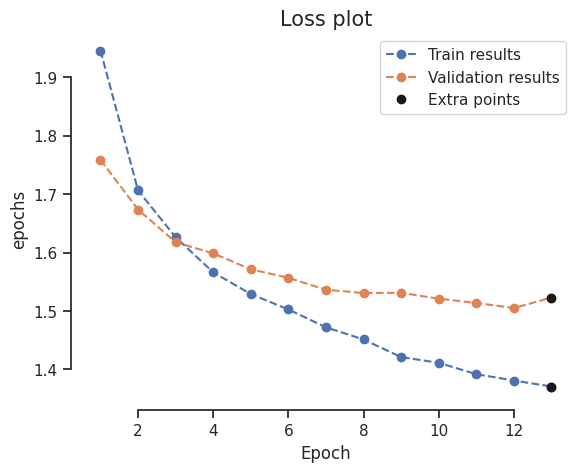

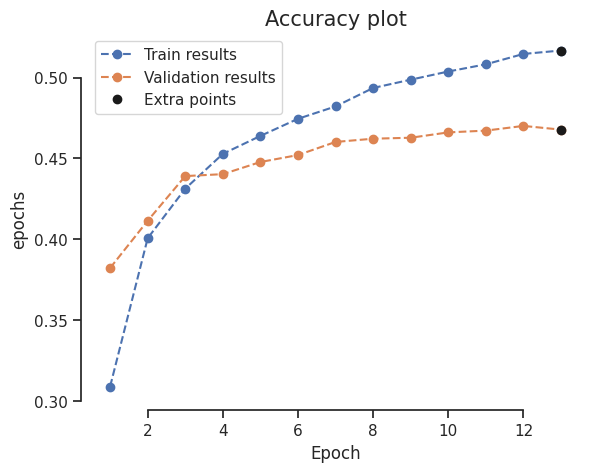

The best value of accuracy of 0.47, occured at 11 epoch
The best value of loss of 1.51, occured at 11 epoch


In [29]:
plot('Loss plot' ,'epochs', 
     train_losses, val_losses, 
     extra_pt = patience, extra_pt_label = 'Extra points')

plot('Accuracy plot' ,'epochs', 
     train_accs, val_accs, 
     extra_pt = patience, extra_pt_label = 'Extra points')

best_val_epoch(val_losses, val_accs)

#### TODO:
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?
- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs. You are allowed to add more arguments to `EarlyStopper.__init__`.
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

**Answer:** We have not reached the best model perfomance. As there some fluctuations in val accuracy we should differ whether decrease of val accurasy occur because of fluctuations or because of trend. That is why we need to increase patience to overcome fluctuations.

In [30]:
patience = 2
num_epochs = 100
model = MLP(img_width, num_in_channels, num_classes).to(device)
optimizer = optim.Adam(model.parameters())
early_stopper = EarlyStopper(verbose=False, path='checkpoint.pt', patience=patience)

#loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
             optimizer, 
             loss_function, 
             device, 
             num_epochs, 
             train_dataloader = trainloader, 
             val_dataloader = valloader, 
             early_stopper =  early_stopper, 
             verbose=False)

Early stopping at epoch 12
Finished training after 137 seconds.


The best value of accuracy of 0.47, occured at 9 epoch
The best value of loss of 1.52, occured at 11 epoch


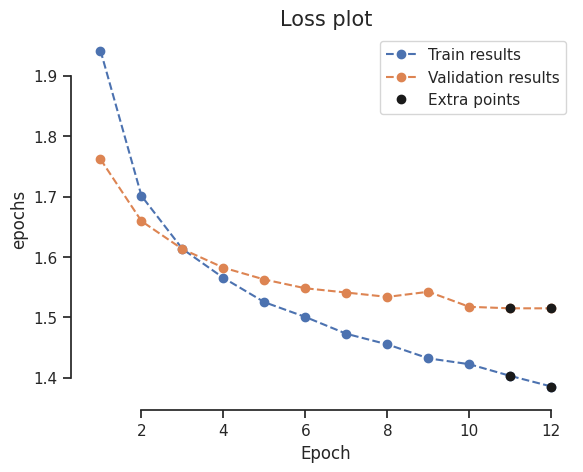

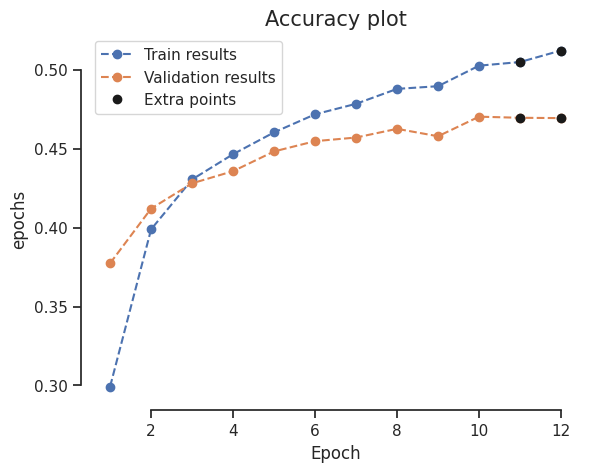

In [31]:
best_val_epoch(val_losses, val_accs)

plot('Loss plot' ,'epochs', 
     train_losses, val_losses, 
     extra_pt = patience, extra_pt_label = 'Extra points')

plot('Accuracy plot' ,'epochs', 
     train_accs, val_accs, 
     extra_pt = patience, extra_pt_label = 'Extra points')

In [32]:
patience = 3
num_epochs = 100
model = MLP(img_width, num_in_channels, num_classes).to(device)
optimizer = optim.Adam(model.parameters())
early_stopper = EarlyStopper(verbose=False, path='checkpoint.pt', patience=patience)

#loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
             optimizer, 
             loss_function, 
             device, 
             num_epochs, 
             train_dataloader = trainloader, 
             val_dataloader = valloader, 
             early_stopper =  early_stopper, 
             verbose=False)

Early stopping at epoch 17
Finished training after 194 seconds.


The best value of accuracy of 0.48, occured at 13 epoch
The best value of loss of 1.51, occured at 14 epoch


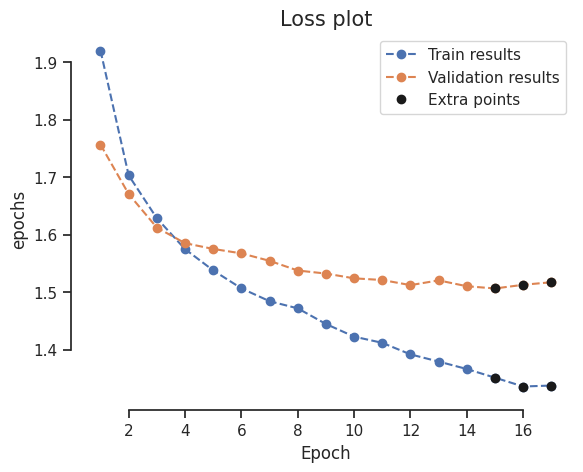

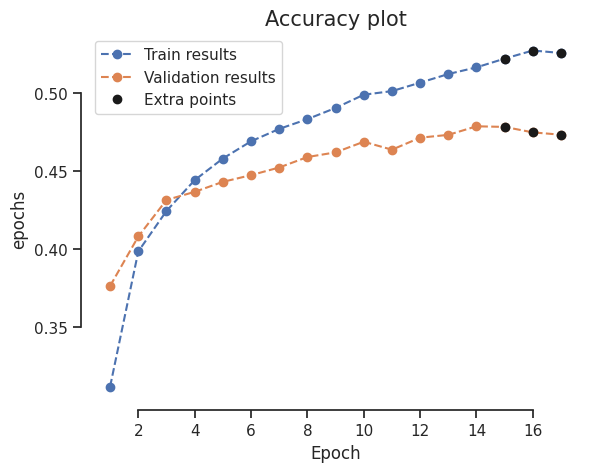

In [33]:
best_val_epoch(val_losses, val_accs)

plot('Loss plot' ,'epochs', 
     train_losses, val_losses, 
     extra_pt = patience, extra_pt_label = 'Extra points')

plot('Accuracy plot' ,'epochs', 
     train_accs, val_accs, 
     extra_pt = patience, extra_pt_label = 'Extra points')

## Which learning rate is best?

Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.

#### TODO:
- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`
- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`
- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do?

In [34]:
lr = 1e-3

####################
## YOUR CODE HERE ##
####################

patience = 3
num_epochs = 100
model = MLP(img_width, num_in_channels, num_classes ).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)
early_stopper = EarlyStopper(verbose=False, path='checkpoint.pt', patience=patience)

#loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
             optimizer, 
             loss_function, 
             device, 
             num_epochs, 
             train_dataloader = trainloader, 
             val_dataloader = valloader, 
             early_stopper =  early_stopper, 
             verbose=False)

Early stopping at epoch 14
Finished training after 160 seconds.


The best value of accuracy of 0.47, occured at 10 epoch
The best value of loss of 1.5, occured at 13 epoch


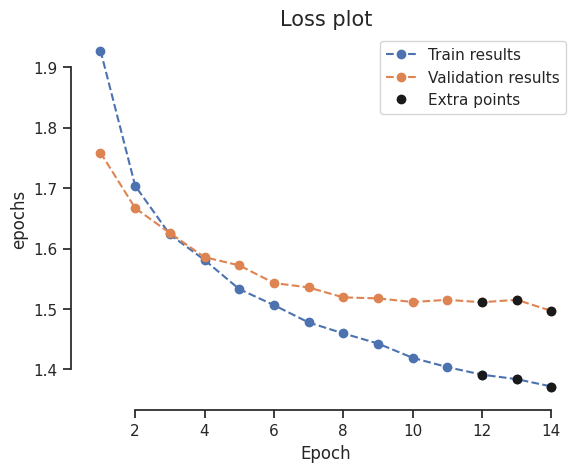

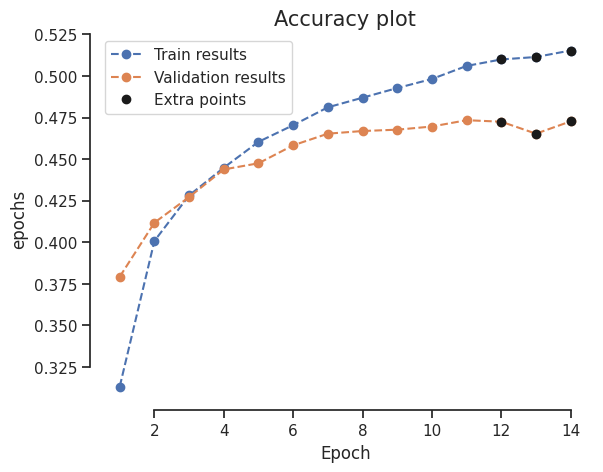

In [35]:
best_val_epoch(val_losses, val_accs)

plot('Loss plot' ,'epochs', 
     train_losses, val_losses, 
     extra_pt = patience, extra_pt_label = 'Extra points')

plot('Accuracy plot' ,'epochs', 
     train_accs, val_accs, 
     extra_pt = patience, extra_pt_label = 'Extra points')

In [36]:
lr = 1e-4

####################
## YOUR CODE HERE ##
####################

patience = 3
num_epochs = 100
model = MLP(img_width, num_in_channels, num_classes ).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)
early_stopper = EarlyStopper(verbose=False, path='checkpoint.pt', patience=patience)

#loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
             optimizer, 
             loss_function, 
             device, 
             num_epochs, 
             train_dataloader = trainloader, 
             val_dataloader = valloader, 
             early_stopper =  early_stopper, 
             verbose=False)

best_val_epoch(val_losses, val_accs)

Early stopping at epoch 51
Finished training after 581 seconds.
The best value of accuracy of 0.47, occured at 47 epoch
The best value of loss of 1.52, occured at 50 epoch


The best value of accuracy of 0.47, occured at 47 epoch
The best value of loss of 1.52, occured at 50 epoch


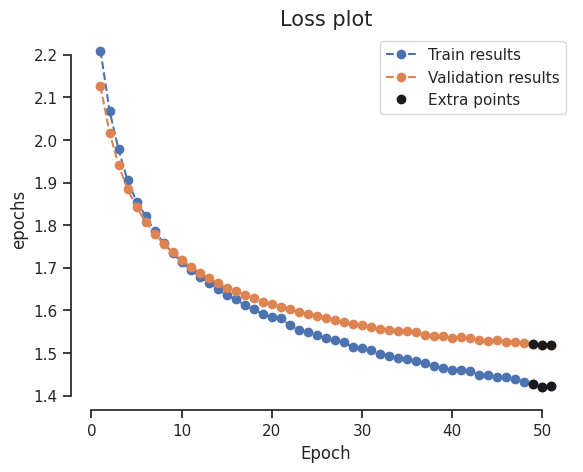

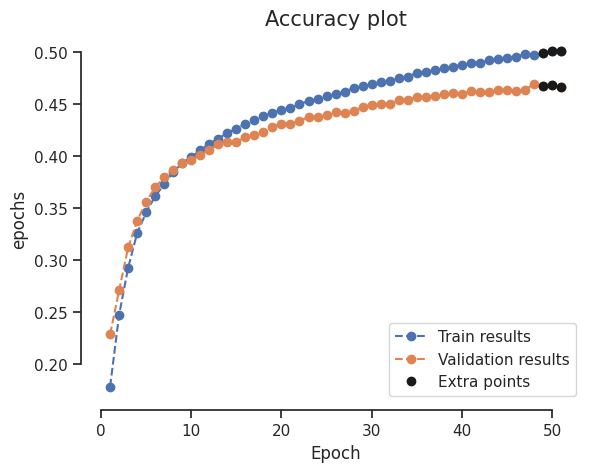

In [37]:
best_val_epoch(val_losses, val_accs)

plot('Loss plot' ,'epochs', 
     train_losses, val_losses, 
     extra_pt = patience, extra_pt_label = 'Extra points')

plot('Accuracy plot' ,'epochs', 
     train_accs, val_accs, 
     extra_pt = patience, extra_pt_label = 'Extra points')

# What about the architecture?

How does architecture affect predictive performance? 

#### TODO:
In the following, try to improve model performance by varying 
- number of  hidden units
- number of layers

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

In [42]:
# number of hidden units
history_units = []
units_range = range(30, 100, 10)
for num_hidden_units in units_range:
    print(f'Number of hidden units is {num_hidden_units}')
    lr = 1e-4
    patience = 3
    num_hidden_layers = 1

    num_epochs = 100
    model = MLP(img_width, num_in_channels, num_classes, 
                num_hidden_units = num_hidden_units, 
                num_hidden_layers = num_hidden_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    early_stopper = EarlyStopper(verbose=False, path='checkpoint.pt', patience=patience)

    loss_function = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
                 optimizer, 
                 loss_function, 
                 device, 
                 num_epochs, 
                 train_dataloader = trainloader, 
                 val_dataloader = valloader, 
                 early_stopper =  early_stopper, 
                 verbose=False)
        
    history_units.append(np.max(val_accs))
    best_val_epoch(val_losses, val_accs)

Number of hidden units is 30


Early stopping at epoch 32
Finished training after 364 seconds.
The best value of accuracy of 0.45, occured at 28 epoch
The best value of loss of 1.58, occured at 31 epoch
Number of hidden units is 40


Early stopping at epoch 54
Finished training after 608 seconds.
The best value of accuracy of 0.48, occured at 50 epoch
The best value of loss of 1.5, occured at 52 epoch
Number of hidden units is 50


Early stopping at epoch 43
Finished training after 488 seconds.
The best value of accuracy of 0.48, occured at 39 epoch
The best value of loss of 1.48, occured at 42 epoch
Number of hidden units is 60


Early stopping at epoch 46
Finished training after 522 seconds.
The best value of accuracy of 0.49, occured at 42 epoch
The best value of loss of 1.45, occured at 45 epoch
Number of hidden units is 70


Early stopping at epoch 53
Finished training after 602 seconds.
The best value of accuracy of 0.5, occured at 49 epoch
The best value of loss of 1.43, occured at 52 epoch
Number of hidden units is 80


Early stopping at epoch 48
Finished training after 565 seconds.
The best value of accuracy of 0.51, occured at 44 epoch
The best value of loss of 1.41, occured at 47 epoch
Number of hidden units is 90


Early stopping at epoch 31
Finished training after 392 seconds.
The best value of accuracy of 0.5, occured at 27 epoch
The best value of loss of 1.43, occured at 30 epoch


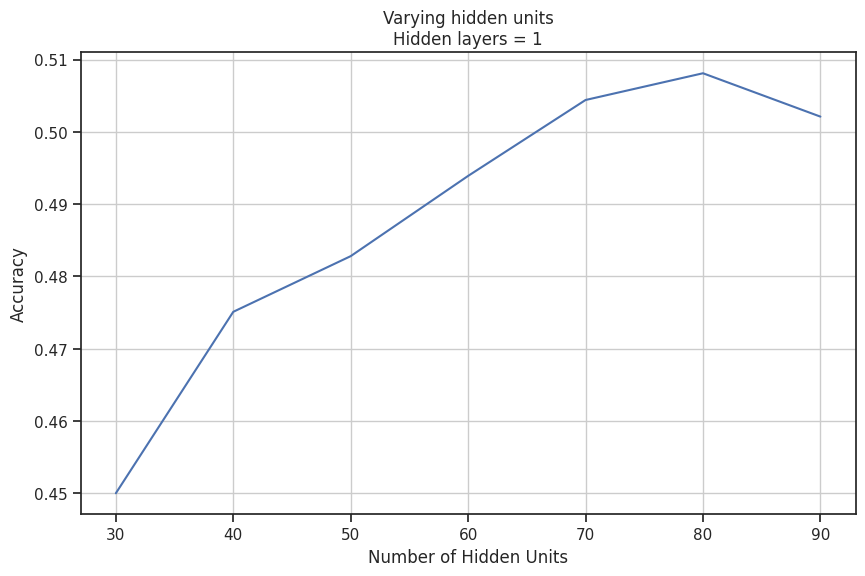

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(units_range, history_units)
plt.title('Varying hidden units\nHidden layers = 1')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Accuracy')
plt.grid(True)

In [50]:
# number of layers
history_layers = []
layers_range = range(2, 10, 2)
for num_hidden_layers in layers_range:
    print(f'Number of hidden layers is {num_hidden_layers}')
    lr = 1e-4
    patience = 3
    num_hidden_units = 30
    #num_hidden_layers = 1

    num_epochs = 100
    model = MLP(img_width, num_in_channels, num_classes, 
                num_hidden_units = num_hidden_units, 
                num_hidden_layers = num_hidden_layers).to(device)    
    
    optimizer = optim.Adam(model.parameters(), lr = lr)
    early_stopper = EarlyStopper(verbose=False, path='checkpoint.pt', patience=patience)

    #loss_function = nn.BCEWithLogitsLoss()
    loss_function = nn.CrossEntropyLoss()
    
    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
                 optimizer, 
                 loss_function, 
                 device, 
                 num_epochs, 
                 train_dataloader = trainloader, 
                 val_dataloader = valloader, 
                 early_stopper =  early_stopper, 
                 verbose=False)

    history_layers.append(np.max(val_accs))
    best_val_epoch(val_losses, val_accs)


Number of hidden layers is 2


Early stopping at epoch 49
Finished training after 625 seconds.
The best value of accuracy of 0.46, occured at 45 epoch
The best value of loss of 1.54, occured at 48 epoch
Number of hidden layers is 4


Early stopping at epoch 57
Finished training after 728 seconds.
The best value of accuracy of 0.45, occured at 53 epoch
The best value of loss of 1.54, occured at 56 epoch
Number of hidden layers is 6


Early stopping at epoch 45
Finished training after 574 seconds.
The best value of accuracy of 0.41, occured at 41 epoch
The best value of loss of 1.63, occured at 44 epoch
Number of hidden layers is 8


Early stopping at epoch 71
Finished training after 907 seconds.
The best value of accuracy of 0.4, occured at 67 epoch
The best value of loss of 1.66, occured at 69 epoch


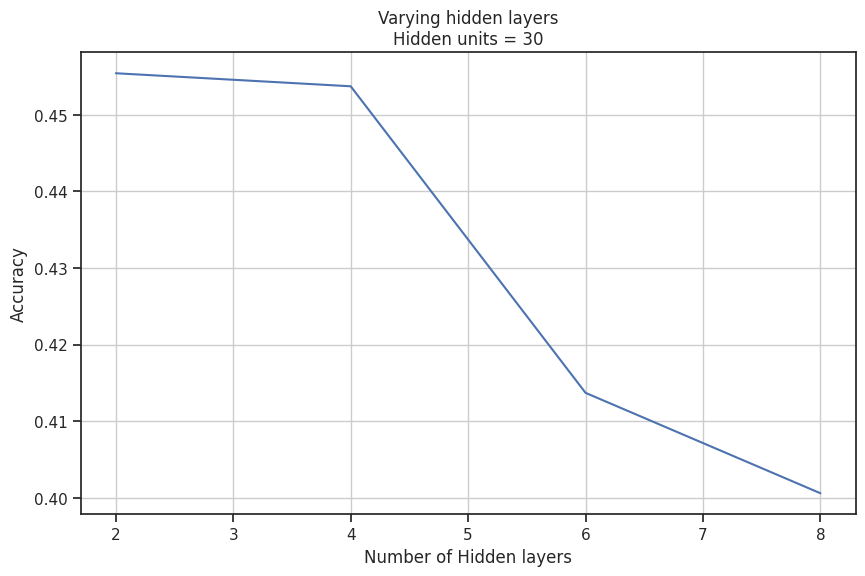

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(layers_range, history_layers)
plt.title('Varying hidden layers\nHidden units = 30')
plt.xlabel('Number of Hidden layers')
plt.ylabel('Accuracy')
plt.grid(True)

#### Questions
- How good do you get?
- Which hyper-parameter makes the largest difference?
- Does it always help to make your model bigger (i.e. wider / deeper)? Why not?

**Your answers:**

1. **How good do you get?**

*Hidden Units*: The best performance was achieved with 80 hidden units, reaching an accuracy of 0.51 at epoch 48, with a corresponding loss of 1.41 at epoch 47. Training with this configuration completed in 570 seconds, indicating it as the optimal choice among tested units.

*Hidden Layers*: The model performed best with 2 hidden layers, achieving 0.46 accuracy at epoch 45, and a minimum loss of 1.54 at epoch 48, with training finishing in 634 seconds. Performance declined with more layers, confirming 2 layers as the most effective setting.

2. **Which hyper-parameter makes the largest difference?**


Our experiments showed that changing the number of hidden units had a clear effect on accuracy, with the best result (0.51) achieved at 80 hidden units. This suggests that more hidden units help the model learn complex patterns in the data.

However, adding more hidden layers didn’t improve accuracy; instead, it actually lowered it. This could be because extra layers make the model too complex, leading to overfitting or inefficient learning. In this case, more hidden units within fewer layers seem to be more effective at capturing important features from the data.

3. **Does it always help to make your model bigger (i.e., wider/deeper)? Why not?**

Increasing model complexity by adding more hidden units or layers does not always result in improved performance. This is due to several factors:

Overfitting: A larger model may fit the training data too closely, capturing noise rather than the underlying patterns, which can lead to poor generalization on validation or test sets.

Diminishing Returns: After a certain point, adding more units or layers yields diminishing returns in performance. The added complexity may not translate into better learning if the model architecture exceeds the problem's requirements.

Training Dynamics: More complex models require more data to train effectively. If the dataset is not sufficiently large or representative, a larger model might struggle to learn generalizable patterns.

Increased Computational Cost: Bigger models demand more computational resources and time for training, which may not be justified by the performance gains.

In our project, increasing the number of hidden layers beyond 2 did not yield improvements in accuracy and instead resulted in lower performance with higher layers. This highlights that a balance must be struck between model complexity and the ability to generalize to unseen data.

Now, here are more TODO's, questions and a little challenge for you: 

#### TODO:
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?
    - When creating the exercise, I got a validation accuracy of 57%
    - Surpassing 50% val. acc. should be possible for you

In [52]:
#Vary all of the parameters at the same time 
size = 8
layers = np.random.randint(low = 2, high=10, size=size, dtype=int)
units = np.random.randint(low = 30, high=90, size=size, dtype=int)

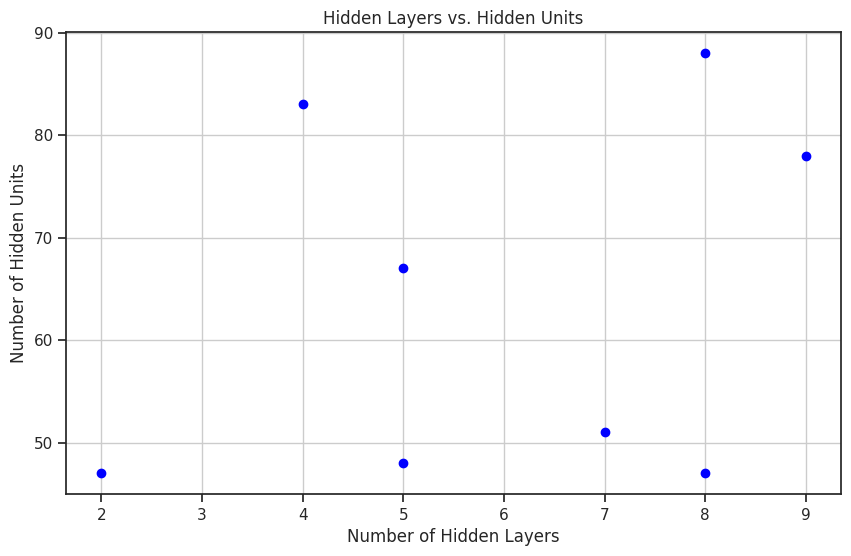

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(layers, units, color='blue')
plt.title('Hidden Layers vs. Hidden Units')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Number of Hidden Units')
plt.grid(True)

In [54]:
for layer, unit in  zip(layers, units):
    lr = 1e-4
    patience = 3
    num_epochs = 10
    num_hidden_units = unit
    num_hidden_layers = layer
    model = MLP(img_width, num_in_channels, num_classes, 
                num_hidden_units = num_hidden_units, num_hidden_layers = num_hidden_layers).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr = lr)
    early_stopper = None
    loss_function = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
                 optimizer, 
                 loss_function, 
                 device, 
                 num_epochs, 
                 train_dataloader = trainloader, 
                 val_dataloader = valloader, 
                 early_stopper =  early_stopper, 
                 verbose=False)
    print(f'N of layers = {layer}\nN of units = {unit}')
    best_val_epoch(val_losses, val_accs)

Finished training after 130 seconds.
N of layers = 9
N of units = 78
The best value of accuracy of 0.34, occured at 9 epoch
The best value of loss of 1.82, occured at 9 epoch


Finished training after 130 seconds.
N of layers = 8
N of units = 47
The best value of accuracy of 0.24, occured at 9 epoch
The best value of loss of 1.94, occured at 9 epoch


Finished training after 130 seconds.
N of layers = 5
N of units = 67
The best value of accuracy of 0.38, occured at 9 epoch
The best value of loss of 1.72, occured at 9 epoch


Finished training after 129 seconds.
N of layers = 7
N of units = 51
The best value of accuracy of 0.35, occured at 9 epoch
The best value of loss of 1.8, occured at 9 epoch


Finished training after 130 seconds.
N of layers = 8
N of units = 88
The best value of accuracy of 0.34, occured at 9 epoch
The best value of loss of 1.77, occured at 9 epoch


Finished training after 129 seconds.
N of layers = 4
N of units = 83
The best value of accuracy of 0.41, occured at 9 epoch
The best value of loss of 1.64, occured at 9 epoch


Finished training after 129 seconds.
N of layers = 5
N of units = 48
The best value of accuracy of 0.36, occured at 9 epoch
The best value of loss of 1.78, occured at 9 epoch


Finished training after 127 seconds.
N of layers = 2
N of units = 47
The best value of accuracy of 0.42, occured at 9 epoch
The best value of loss of 1.66, occured at 9 epoch


# Guessing the best parameters.

We've noticed that increasing the number of hidden layers makes our model more complex, which actually lowers accuracy. While increasing number of hidden units gives us better accurasy. Let's experiment with the number of hidden units more.

Since our images are 32x32 pixels (1024 pixels total), we can start by setting the hidden units to match this pixel count. This way, the model can try to calculate weights for each pixel individually. The idea behind it is that out model will get all the information from the image. This is our best initial guess, but we'll need to test it to see if it improves performance.


In [81]:
patience = 4
num_epochs = 100
num_hidden_layers = 3
num_hidden_units = 1024
model = MLP(img_width, num_in_channels, num_classes,
           num_hidden_units = num_hidden_units, num_hidden_layers = num_hidden_layers).to(device)
optimizer = optim.Adam(model.parameters())
early_stopper = EarlyStopper(verbose=False, path='checkpoint.pt', patience=patience)

#loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, 
             optimizer, 
             loss_function, 
             device, 
             num_epochs, 
             train_dataloader = trainloader, 
             val_dataloader = valloader, 
             early_stopper =  early_stopper, 
             verbose=False)

Early stopping at epoch 17
Finished training after 219 seconds.


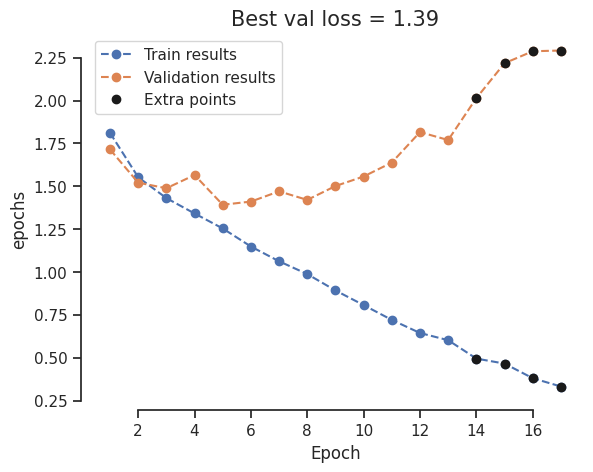

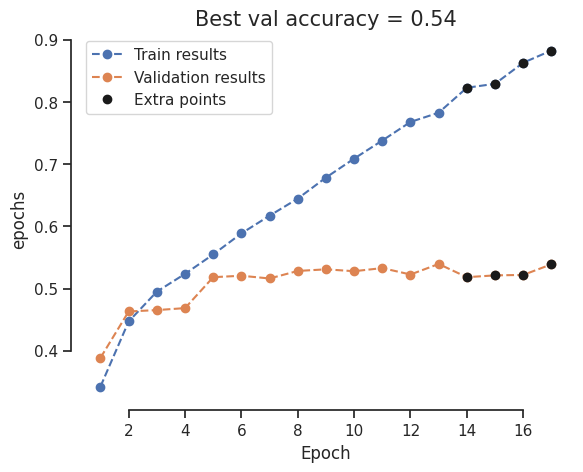

In [82]:
plot(f'Best val loss = {round(min(val_losses),2)}' ,'epochs', 
         train_losses, val_losses, 
         extra_pt = patience, extra_pt_label = 'Extra points')

plot(f'Best val accuracy = {round(max(val_accs),2)}' ,'epochs', 
         train_accs, val_accs, 
         extra_pt = patience, extra_pt_label = 'Extra points')

Our guess worked well)

#### Questions:
- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?
- What could we do about this?
    - *Hint:* there are actually multiple answers to this question. 
    - One could be to change model training and evaluation. How?
    - The other could be to use a more sophisticated analysis. How?

##### 1. If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?

When training the same model multiple times from scratch, you may not get the same performance due to several factors, including the initialization of model weights, the stochastic nature of optimization algorithms (such as Adam), and variations in data shuffling during training. This variability means that different runs of the same model architecture and parameters may yield different results, making it challenging to compare models trained with different hyperparameters directly.

In our results, the first set of experiments yielded significantly lower accuracy (up to 0.41) compared to the second set (with a best accuracy of 0.51). These differences suggest that the models trained with random hyperparameter settings may not be directly comparable to the model with chosen optimal values.

##### 2. What could we do about this?

Multiple Approaches:

1. Change Model Training and Evaluation:

   - Cross-Validation: Instead of relying on a single validation split, you could use k-fold cross-validation. This involves dividing the dataset into k subsets and training the model k times, each time using a different subset as validation and the remaining subsets for training. This helps to get a more robust estimate of model performance and reduces the influence of random initialization and data shuffling.

   - Ensemble Methods: Training multiple models and averaging their predictions can help to mitigate the impact of randomness. Techniques like bagging (e.g., Random Forests) or boosting (e.g., AdaBoost) can improve robustness and accuracy.


2. Use a More Sophisticated Analysis:

   - Hyperparameter Tuning: Implement systematic approaches for hyperparameter tuning such as grid search or random search. This can involve searching through a range of hyperparameters rather than relying on a single random sample. You can use libraries like Optuna or Ray Tune for automated hyperparameter optimization.

   - Experiment Logging: Utilize experiment tracking tools like Weights & Biases or MLflow to log parameters, metrics, and model configurations. This allows for better comparison of model performance across different runs and helps in identifying patterns and trends.

   - Statistical Analysis: Conduct statistical tests to compare the performance of different models. For instance, you can use paired t-tests to determine if the performance differences are statistically significant.


By employing these strategies, we can improve the reliability of your model evaluations and ensure that the conclusions drawn from different experiments are more valid and comparable. This will ultimately lead to better model selection and improved predictive performance.

# Evaluate your best model on test set, once!

When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO:
- What is the accuracy of the best model you found on the test set?
- Plot the confusion matrix, too!

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test(test_loader, model, device):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """
    
    ####################
    ## YOUR CODE HERE ##
    ####################

    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            conf_matrix = confusion_matrix(np.array(y.cpu()), np.array(y_pred.argmax(dim=1).cpu()))
        

    return accuracy(epoch_correct, epoch_total), conf_matrix


In [84]:
test_accuracy, cm =  test(testloader, model, device)

In [85]:
print(f'Accuracy on test data = {test_accuracy}')

Accuracy on test data = 0.5247


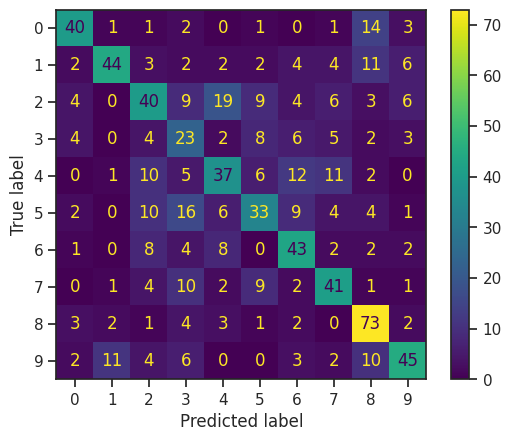

In [86]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot()
plt.show()

*Hint:* Use sklearn to create the confusion matrix ([link](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.confusion_matrix.html))

#### Questions:
- On which classes is your model's prediction poor?
- Is the test accuracy of your model as good as the validation accuracy?
- If those values are different: How can you explain the difference?
- Why should you never use test set performance when trying out different hyper-parameters and architectures?

#### Answers:

##### 1.	On which classes is your model’s prediction poor?

This can be observed by the relatively low numbers on the diagonal for these classes (indicating correct predictions) and higher misclassification counts in other columns. Below is a summarized analysis of the model’s performance on each class based on the confusion matrix:

Classification of class 8 (ship) is the best (73), however classes 0,1,9 (airplane, automobile, truck) sometimes can also be classified as class 8. The worst perfomance of the model observed on class 3 (cat), which model tend to classify as class 5 and 6 (dog, frog). Also there is evidence that model confusing with classes 2 (bird) and sometimes predict class 4 (deer). But overall we see, that our model works good and can substract basic featurs from the images.

##### 2. Is the test accuracy of your model as good as the validation accuracy?

In this case, the test accuracy is 0.5012, which is close to the validation accuracy achieved earlier (0.51). This suggests that the model’s performance on the test set is roughly in line with its performance on the validation set. The small difference could be due to inherent variations between the data used for validation and testing. However, if the validation accuracy had been significantly higher than the test accuracy, it might indicate issues such as overfitting or underfitting, depending on the model’s behavior across training, validation, and test sets.

##### 3. If those values are different: How can you explain the difference?

If there were a more pronounced difference between the validation and test accuracy, several factors could explain it:

- Overfitting: The model may have learned patterns specific to the validation set but fails to generalize well to the test set, especially if the validation set does not represent the overall data distribution effectively.

- Data Leakage: Any overlap between the validation and training sets, or improper randomization of the validation set, could lead to an inflated validation accuracy, making it appear higher than the test set performance.

- Variance in Data: The test set might contain samples that are inherently more challenging to classify compared to the validation set, causing a drop in accuracy.

- Insufficient Regularization: If regularization is inadequate, the model may overfit to the training/validation data and struggle with unseen data.

- Limited Training Data: With insufficient training data, the model might perform well on validation samples but face difficulties generalizing to new data, like the test set.

##### 4. Why should you never use test set performance when trying out different hyper-parameters and architectures?

Using the test set for hyperparameter tuning or model selection introduces several critical issues:

- Overfitting Risk: Evaluating models multiple times on the test set can lead to “overfitting” on that particular data, meaning the model may adapt to specific patterns in the test set rather than learning generalizable features. This reduces the model’s ability to perform well on genuinely unseen data.
- Biased Performance Estimates: If the test set is repeatedly used during model development, performance metrics may become overly optimistic. This bias creates a misleading picture of the model’s true capabilities and hinders the accurate assessment of its real-world performance.
- Data Integrity: The test set should remain untouched until final evaluation. Using it earlier compromises its purpose as an objective benchmark, undermining the reliability of the final performance evaluation.

The test set should serve as a final, unbiased measure of the model’s generalization ability. It’s meant only for evaluating how the model would perform in real-world scenarios, where predictions are made on new, unseen data. By keeping the test set separate from training and validation, we maintain its integrity as an objective measure of the model’s generalization ability.

## How about the optimizer? _(Optional)_

_This task is optional, you do not need to solve it_

Now let's check out what difference it makes to use different optimizers in the learning strategy and what effect it has on the performance.

#### TODO *(Optional)*:

- Run training of the same model used above with
    - different optimizers (_hint_ - https://pytorch.org/docs/stable/optim.html)
- Compare your training results of all the different optimizer settings from above.
- What is your observation while using different optimizers? What is the respective impact on the model performance?

## Explore batch size *(Optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(Optional)*:
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 512 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 and 1024 (from above)
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

*Hint*: You have to initialize new data loaders, as they provide you with batches during training.

In [51]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

In [52]:
# Batch size 512

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

(OPTIONAL) You should evaluate on the test set with the optional solutions here (and see if they lead to performance gain).

In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials. You don't need to present the optional exercises

## Explore Activation Function _(Optional)_

*This task is optional, you do not need to solve it*

### TODO _(Optional)_:

Let's change activation function used (e.g. see [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity))
- Run training of the same model used above with a new activation function 
- Compare your training results

In [53]:
###############################
## YOUR CODE HERE - OPTIONAL ##
###############################